# Getting started with stitchee's Harmony service-chain

## Overview

This Jupyter notebook demonstrates how to use the "**Subsetter And Multi-dimensional Batched Aggregation in Harmony (SAMBAH)**", a service chain in the backend of NASA Earthdata that transforms level 2 data into a merged output product. This notebook will use harmony-py and a variety of input arguments that can be given to the service to define the output.

## Table of Contents
1. Intro to the SAMBAH service chain
2. Setup
3. Forming and submitting requests to the SAMBAH service chain
4. Define plotting functions
5. Request example #1: Concatenate with Temporal subsetting
6. Request example #2: Concatenate with Temporal and Spatial subsetting
7. Request example #3: Concatenate with Temporal, Spatial, and Variable subsetting

# 1. Intro to the SAMBAH service chain

This service chain operates by executing four sequential steps:
1. **Performing subsetting on each file**
    - Uses L2-Subsetter
    - Performed in parallel for each file
3. **Identifying which data files should be grouped together for subsequent concatenation operations**
    - Uses Batchee
    - A single operation
4. **Concatenating data files, by "extending" one of the arrays' existing dimensions**
    - Uses STICHEE
    - Performed in parallel for each batch identified in the previous step
5. **Concatenating the results of the previous step along a new dimension**
    - Uses CONCISE
    - A single operation, but performed in parallel if file size limit is exceeded

The following GIF illustrates the above-mentioned steps 3 and 4:
![ExtendAndStackGIF](concat_extend_and_stack.gif "extend and stack gif")

# 2. Setup
---

In [1]:
import datetime as dt
import os

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from harmony import BBox, CapabilitiesRequest, Client, Collection, Request
from IPython.display import JSON

**Authentication:** Before we can use the service we need to initialize a Harmony `Client` object, which requires an account with NASA Earthdata Login (EDL)

In [2]:
harmony_client = Client()

# 3. Forming and submitting requests to the SAMBAH service chain
---

The SAMBAH service chain allows a user to make requests that specify several parameters, such as:

- The data dimension along which intermediate steps will concatenate ("`extend`")
- The target temporal range for subsetting ("`temporal`")
- The target spatial domain for subsetting ("`spatial`")
- The target variables for subsetting ("`variables`")

### Specify a collection to make requests against

This is a $NO_2$ column data product from the Tropospheric Emissions Monitoring of Pollution (TEMPO) instrument, with this [CMR entry in UAT](https://cmr.earthdata.nasa.gov/search/concepts/C2930725014-LARC_CLOUD.html).

In [3]:
collection_id = "C2930725014-LARC_CLOUD"

##### Let's examine the current Harmony capabilities for a collection from the Tropospheric Emissions: Monitoring of Pollution (TEMPO) mission.

> Note that the SAMBAH service chain is written in the JSON as "l2-subsetter-batchee-stitchee-concise"

In [4]:
capabilities_request = CapabilitiesRequest(collection_id=collection_id)
capabilities = harmony_client.submit(capabilities_request)

JSON(capabilities, expanded=True)

<IPython.core.display.JSON object>

# 4. Define utility functions
---

In [5]:
def download_harmony_results(jobid: str) -> list:
    """Download the results of a Harmony job using the job id."""
    output_files = []

    for url in harmony_client.result_urls(jobid):
        step_id, filename = url.split("/")[-2:]

        os.makedirs(f"uat/{jobid}/{step_id}", exist_ok=True)

        future = harmony_client.download(url, directory=f"uat/{jobid}/{step_id}")
        output_files.append(future.result())

    return output_files

In [6]:
def get_XYC(filepath, product_name, index=-1):
    """Return longitude, latitude, and data values for a given file and product variable."""
    ds_root = xr.open_dataset(filepath)
    ds_product = xr.open_dataset(filepath, group="product")
    ds_geo = xr.open_dataset(filepath, group="geolocation")

    if index < 0:
        X, Y, C = (
            ds_geo.longitude.values,
            ds_geo.latitude.values,
            ds_product[product_name].values,
        )
        filename = filepath
    else:
        X, Y, C = (
            ds_geo.longitude[index].values,
            ds_geo.latitude[index].values,
            ds_product[product_name][index].values,
        )
        filename = ds_root.subset_files.data[index]
    inds = np.logical_not(np.isnan(X) | np.isnan(Y) | np.isnan(C))

    return filename, X[inds], Y[inds], C[inds]

In [7]:
def plot_map(ax, h2d, extent: list = [-140, -15, 15, 65]):
    """Make a pseudocolor map with some generic Earth features on the given axis."""
    proj = ccrs.PlateCarree()
    cmp = plt.cm.nipy_spectral_r

    ax.set_extent(extent, crs=proj)

    ax.add_feature(
        cfeature.COASTLINE.with_scale("10m"), linewidth=0.1, edgecolor="dimgray"
    )
    ax.add_feature(
        cfeature.OCEAN, linewidth=0.1, edgecolor="dimgray", facecolor="lightsteelblue"
    )
    ax.add_feature(
        cfeature.LAKES, linewidth=0.1, edgecolor="dimgray", facecolor="lightsteelblue"
    )
    ax.add_feature(cfeature.BORDERS, linewidth=0.1, edgecolor="dimgray")
    ax.add_feature(
        cfeature.STATES.with_scale("10m"), linewidth=0.1, edgecolor="dimgray"
    )

    (H, xbins, ybins) = h2d
    H = H.T
    ax.pcolormesh(xbins, ybins, H, norm="log", cmap=cmp, alpha=0.8)
    return ax


def plot_map_histogram2d(files: list, extent: list = [-140, -15, 15, 65]) -> None:
    """Make a histogram/density map of data points from the given files."""
    proj = ccrs.PlateCarree()
    XYCs = [get_XYC(fn, "vertical_column_troposphere") for fn in files]

    fig, axs = plt.subplots(
        figsize=(8, 6.5),
        dpi=300,
        facecolor="w",
        subplot_kw=dict(projection=proj),
        linewidth=8,
        edgecolor="white",
        layout="compressed",
    )
    h2d = np.histogram2d(
        np.concatenate([xx for ff, xx, yy, cc in XYCs]),
        np.concatenate([yy for ff, xx, yy, cc in XYCs]),
        weights=np.concatenate([cc for ff, xx, yy, cc in XYCs]),
        bins=100,
    )

    plot_map(axs, h2d, extent)

# 5. Request example #1: Concatenate with Temporal subsetting
---

In [8]:
request = Request(
    collection=Collection(id=collection_id),
    temporal={
        "start": dt.datetime(2024, 1, 23, 21, 27, 0),
        "stop": dt.datetime(2024, 1, 23, 21, 40, 0),
    },
    extend="mirror_step",
)
assert request.is_valid()

job_id = harmony_client.submit(request)
harmony_client.wait_for_processing(job_id, show_progress=True)

 [ Processing: 100% ] |###################################################| [|]


In [9]:
data = harmony_client.status(job_id)
JSON(data)

<IPython.core.display.JSON object>

In [10]:
files_list = download_harmony_results(job_id)

uat/b1c33cb9-3f0e-4cb4-9dba-d0bdc64ab72e/79749916/79749916_TEMPO_NO2_L2_V03_20240123T212036Z_S011G01_subsetted.nc4
uat/b1c33cb9-3f0e-4cb4-9dba-d0bdc64ab72e/79749917/79749917_TEMPO_NO2_L2_V03_20240123T212716Z_S011G02_subsetted.nc4
uat/b1c33cb9-3f0e-4cb4-9dba-d0bdc64ab72e/79749918/79749918_TEMPO_NO2_L2_V03_20240123T213356Z_S011G03_subsetted.nc4
uat/60c87fb6-0ce7-4273-9465-f6534b2efeed/79749920/79749920_TEMPO_NO2_L2_V03_20230802T153741Z_S001G05_subsetted.nc4
uat/60c87fb6-0ce7-4273-9465-f6534b2efeed/79749921/79749921_TEMPO_NO2_L2_V03_20230802T154354Z_S001G06_subsetted.nc4
uat/60c87fb6-0ce7-4273-9465-f6534b2efeed/79749923/79749923_TEMPO_NO2_L2_V03_20230802T164012Z_S002G05_subsetted.nc4
uat/60c87fb6-0ce7-4273-9465-f6534b2efeed/79749922/79749922_TEMPO_NO2_L2_V03_20230802T155007Z_S001G07_subsetted.nc4
uat/60c87fb6-0ce7-4273-9465-f6534b2efeed/79749924/79749924_TEMPO_NO2_L2_V03_20230802T164625Z_S002G06_subsetted.nc4
uat/60c87fb6-0ce7-4273-9465-f6534b2efeed/79749925/79749925_TEMPO_NO2_L2_V03_2023

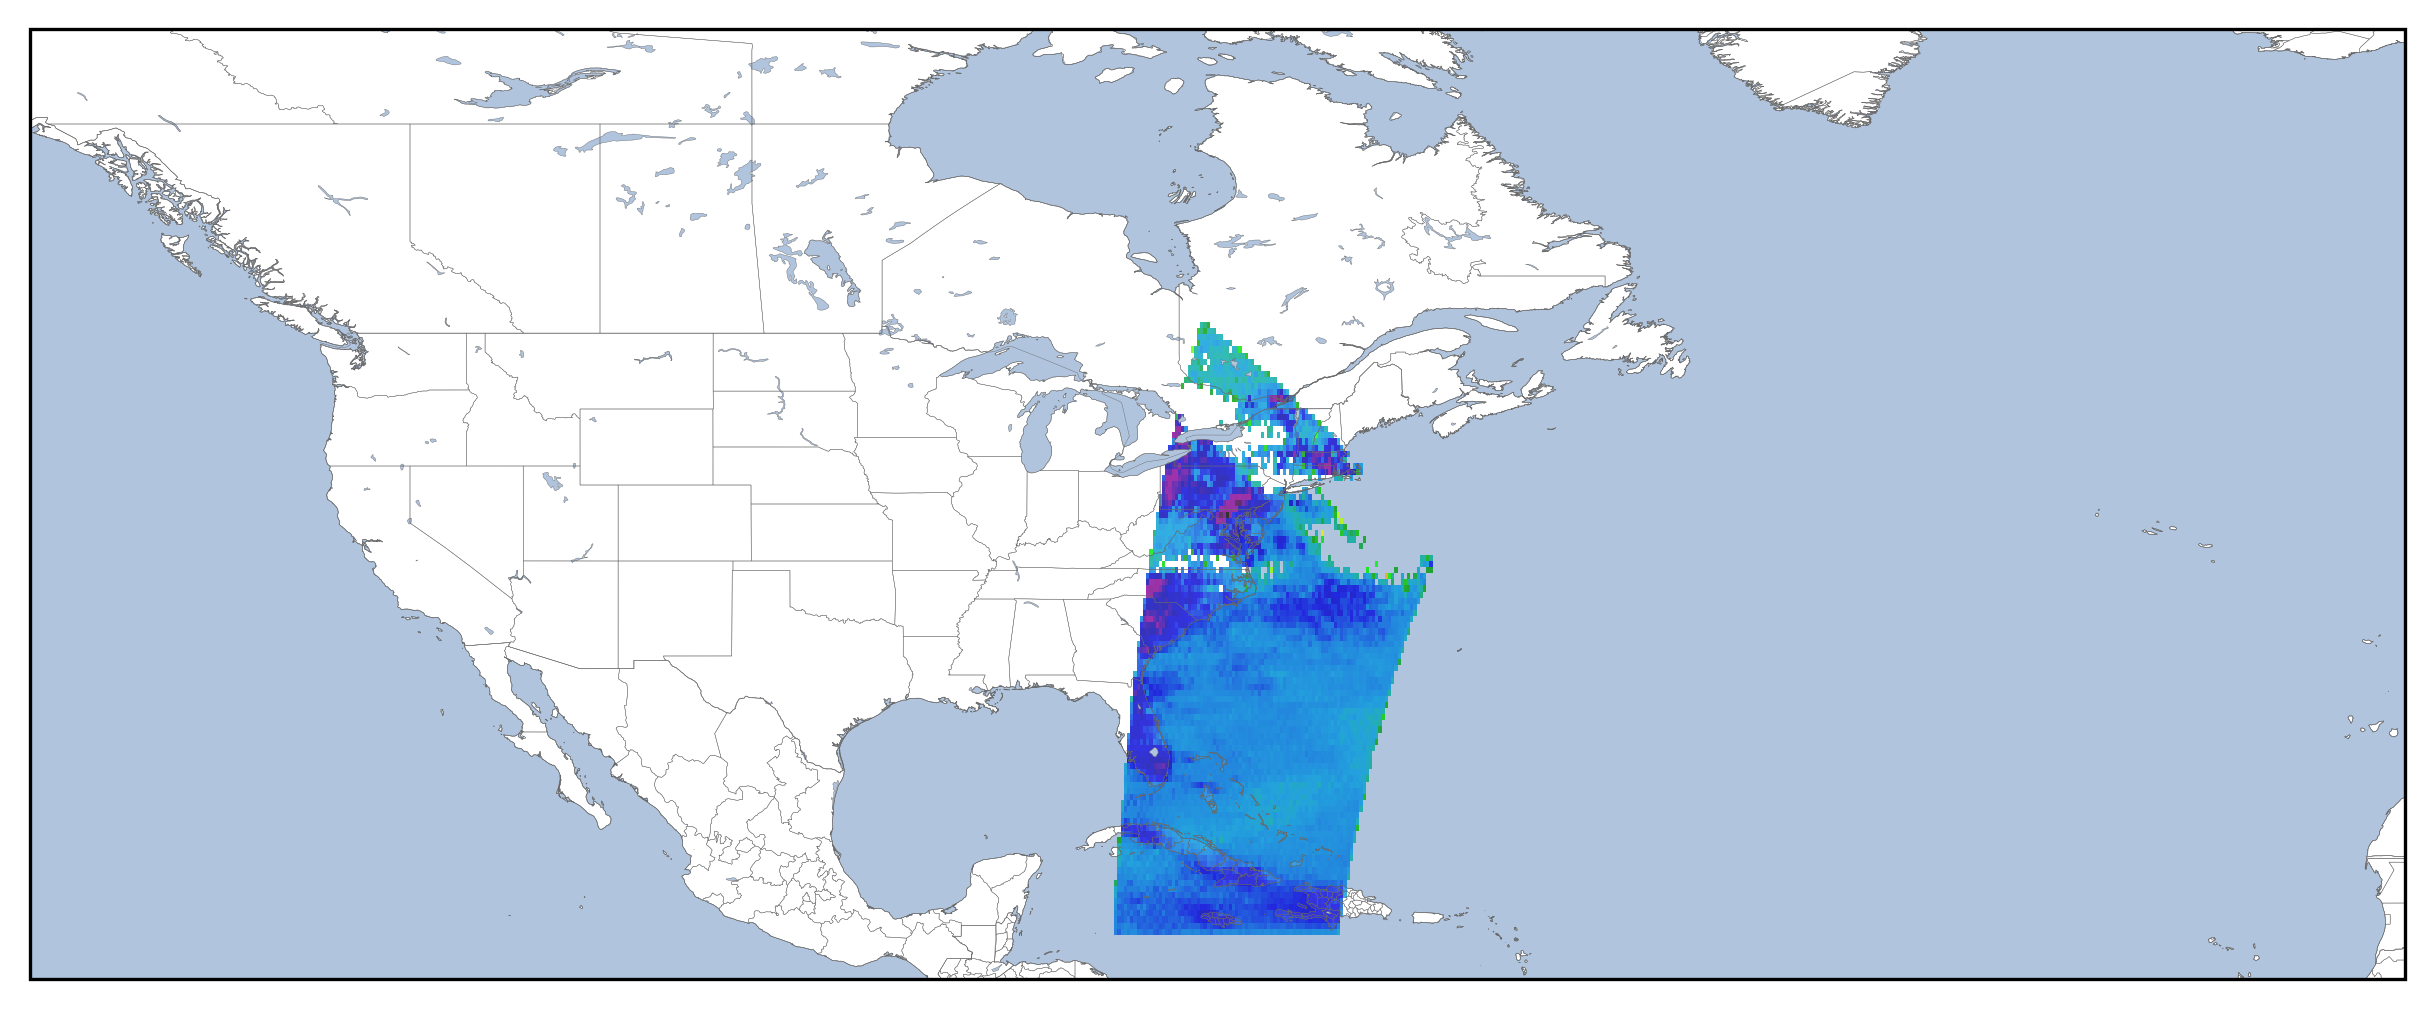

In [11]:
plot_map_histogram2d(files_list)

# 6. Request example #2: Concatenate with Temporal and Spatial subsetting
---

In [12]:
request = Request(
    collection=Collection(id=collection_id),
    spatial=BBox(-100, 30, -90, 40),
    extend="mirror_step",
    max_results=10,
)
assert request.is_valid()

job_id = harmony_client.submit(request)
harmony_client.wait_for_processing(job_id, show_progress=True)

 [ Processing: 100% ] |###################################################| [|]


In [13]:
files_list = download_harmony_results(job_id)

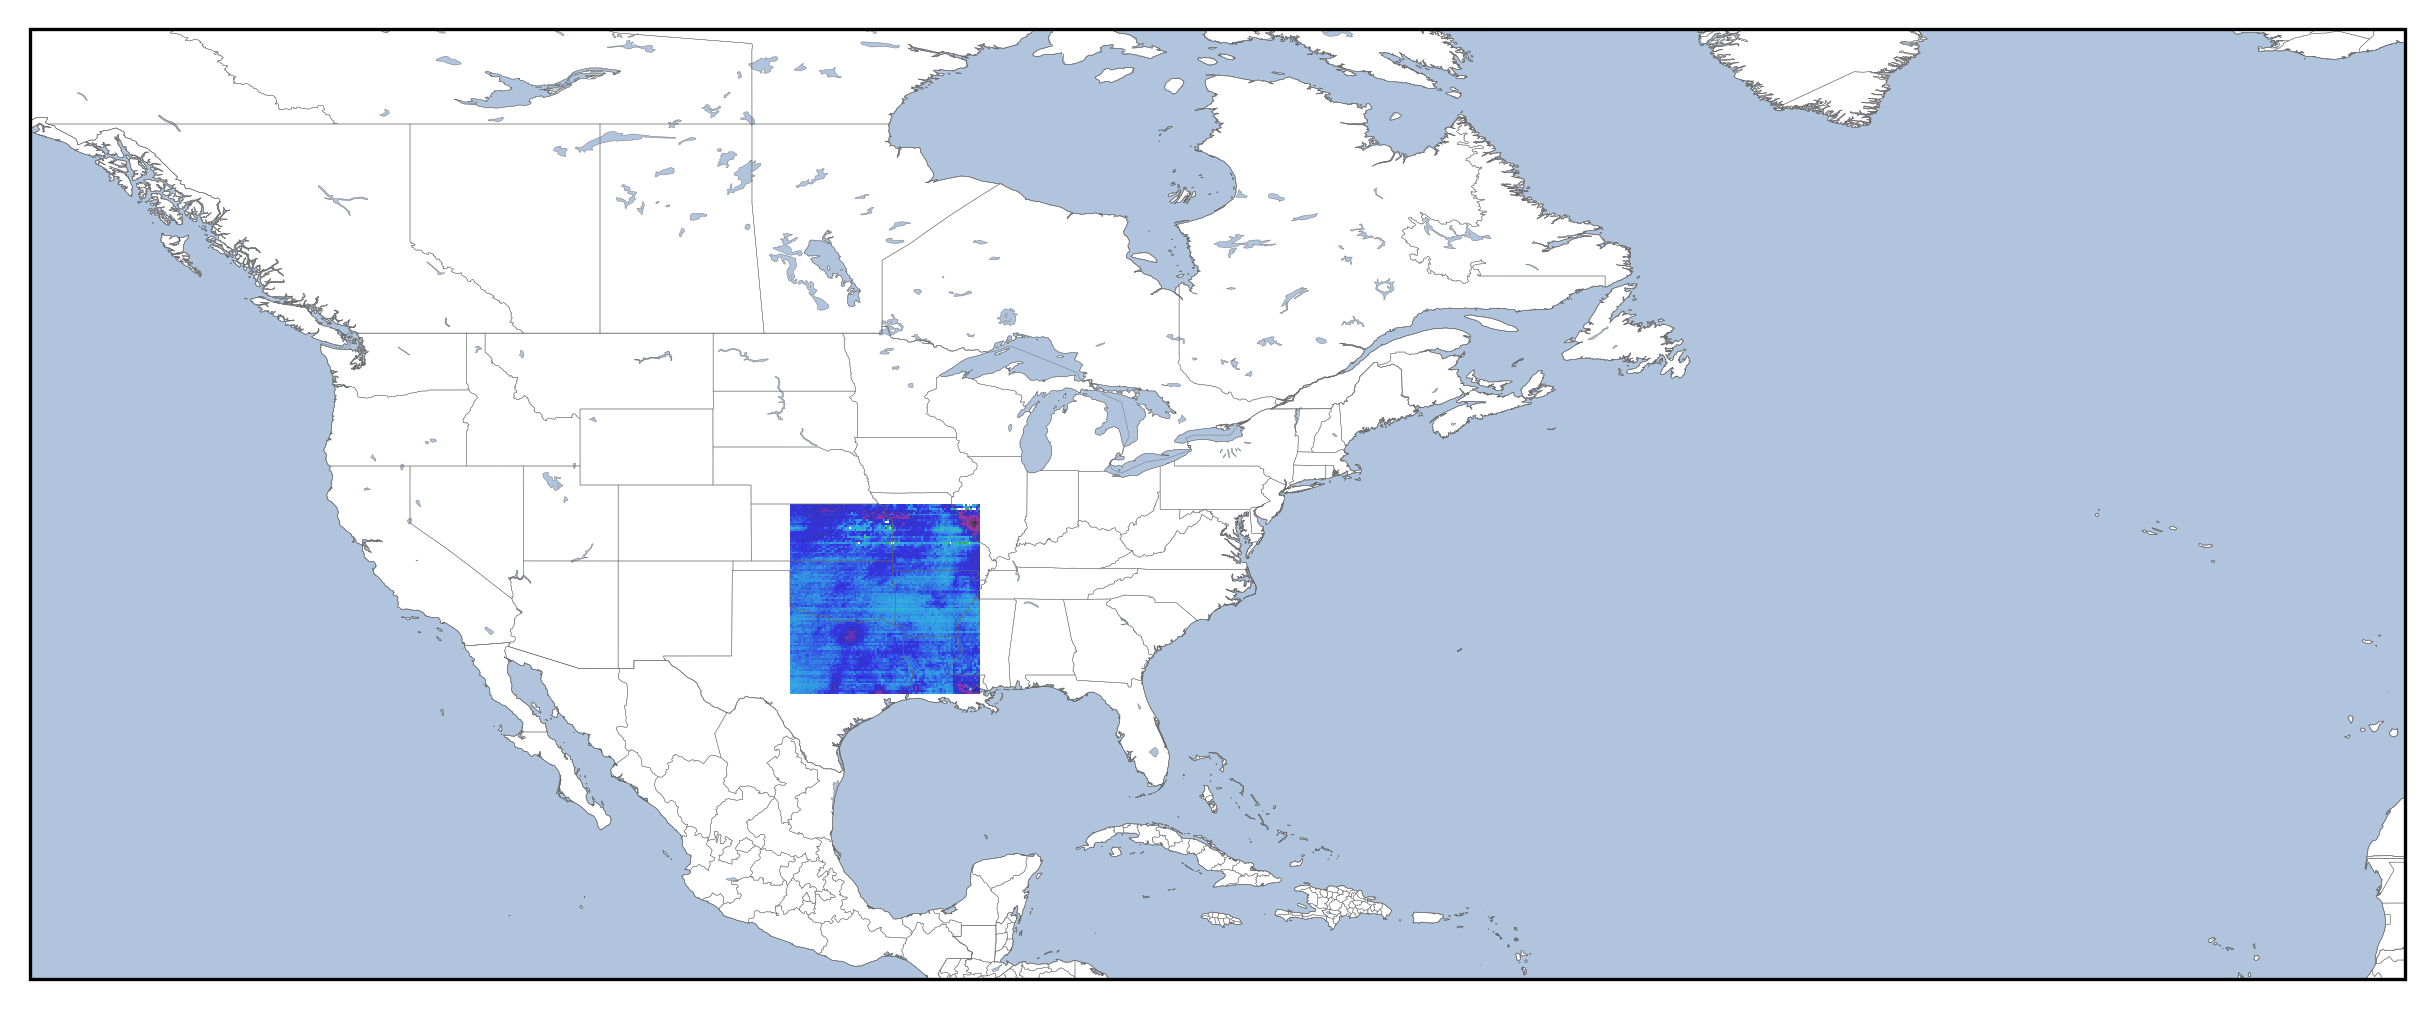

In [14]:
plot_map_histogram2d(files_list)

# 7. Request example #3: Concatenate with Temporal, Spatial, and Variable subsetting
---

In [15]:
request = Request(
    collection=Collection(id=collection_id),
    variables=["product/vertical_column_troposphere"],
    spatial=BBox(-100, 30, -90, 40),
    temporal={
        "start": dt.datetime(2024, 1, 23, 13, 26, 58),
        "stop": dt.datetime(2024, 1, 23, 13, 33, 34),
    },
    extend="mirror_step",
)
assert request.is_valid()

job_id = harmony_client.submit(request)
harmony_client.wait_for_processing(job_id, show_progress=True)

 [ Processing: 100% ] |###################################################| [|]


In [16]:
files_list = download_harmony_results(job_id)

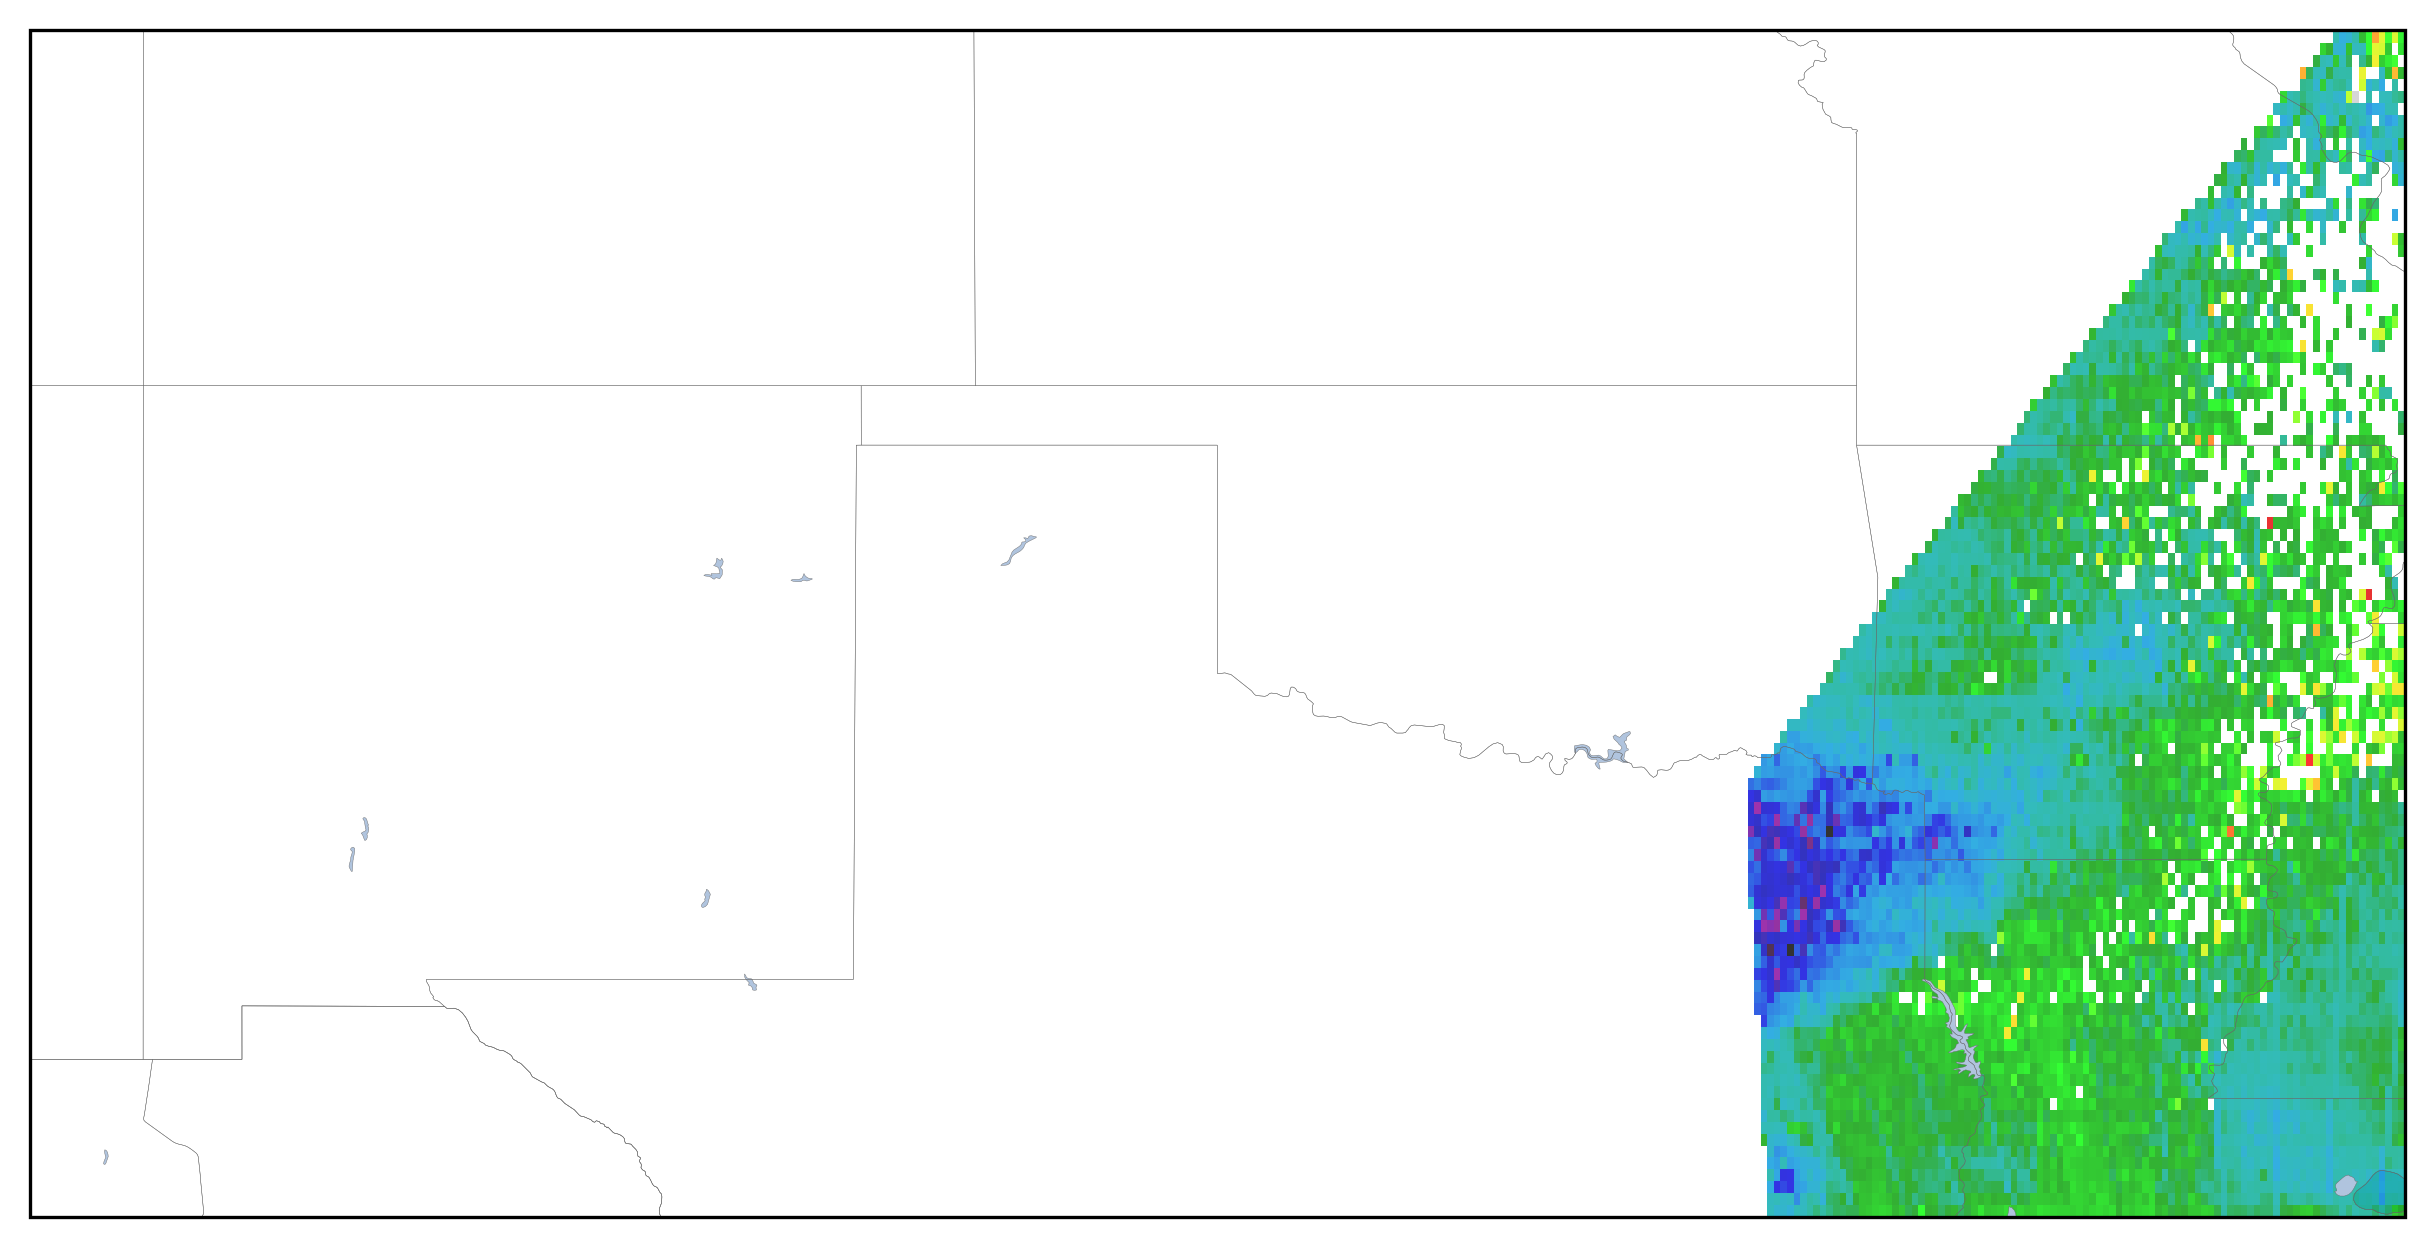

In [17]:
plot_map_histogram2d(files_list, extent=[-110, -90, 30, 40])

END of Notebook.